In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('trip_count_sql').getOrCreate()

directory = '/home/ubuntu/working/spark-examples/data'
trip_files = 'trips/'

trips_df = spark.read.csv(f'file://{directory}/{trip_files}',
                         inferSchema = True,
                         header = True)

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/14 04:44:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/06/14 04:44:02 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
trips_df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)



In [3]:
trips_df.createOrReplaceTempView('trips')

Lake -> Warehouse -> Mart
- Mart에 있는 데이터를 기준으로 해서 Application이 만들어짐
- 딥러닝, 머신러닝 -> Warehouse 단계 데이터에서 이뤄짐

- **Warehouse에서 feature, target을 꺼내와서 만든 것이 Mart**

운행거리(`trip_distance`)에 따른 요금(`total_amount`)를 예측
- where절은 EDA 결과를 따라가면 됨

TO_DATE를 쓰면 (	2021-05-15 08:30:00) -> 여기서 날짜만 남게됨

In [4]:
query = """
    SELECT trip_distance,
            total_amount
    FROM trips
    WHERE total_amount < 5000
    AND total_amount > 0
    AND passenger_count < 5
    AND trip_distance > 0
    AND trip_distance < 500
    AND TO_DATE(tpep_pickup_datetime) >= '2021-01-01'
    AND TO_DATE(tpep_pickup_datetime) < '2021-08-01'
    ORDER BY trip_distance DESC
"""

spark.sql(query).show(5)

+-------------+------------+
|trip_distance|total_amount|
+-------------+------------+
|        475.5|        48.3|
|        474.1|        46.8|
|        452.0|       60.16|
|        449.9|       56.75|
|       439.74|       13.73|
+-------------+------------+
only showing top 5 rows



In [5]:
data_df = spark.sql(query)
data_df.createOrReplaceTempView('data') # 데이터 마트 구성

In [6]:
data_df.show()

+-------------+------------+
|trip_distance|total_amount|
+-------------+------------+
|        475.5|        48.3|
|        474.1|        46.8|
|        452.0|       60.16|
|        449.9|       56.75|
|       439.74|       13.73|
|        439.0|       18.87|
|        433.7|       44.05|
|        427.7|      2292.4|
|        423.6|        53.3|
|        418.1|        65.8|
|       411.67|       86.21|
|        402.9|        39.8|
|        402.7|        56.8|
|        399.5|       42.05|
|        391.9|       49.35|
|        389.7|       56.95|
|        385.0|        40.8|
|        380.3|       39.35|
|        377.3|        40.1|
|        370.4|       43.25|
+-------------+------------+
only showing top 20 rows



# 데이터 분리

In [7]:
train_df, test_df = data_df.randomSplit([0.8,0.2], seed=42)

# 훈련 데이터 캐싱
- 전처리가 모델마다 다를 수 있기 때문에 전처리 후에 캐싱하지 않는 것

In [8]:
train_df.cache()

DataFrame[trip_distance: double, total_amount: double]

In [9]:
train_df.count(), len(train_df.columns)

(10659431, 2)

In [10]:
test_df.count(), len(test_df.columns)

(2665618, 2)

count()는 full-scan 작업이라서 느림

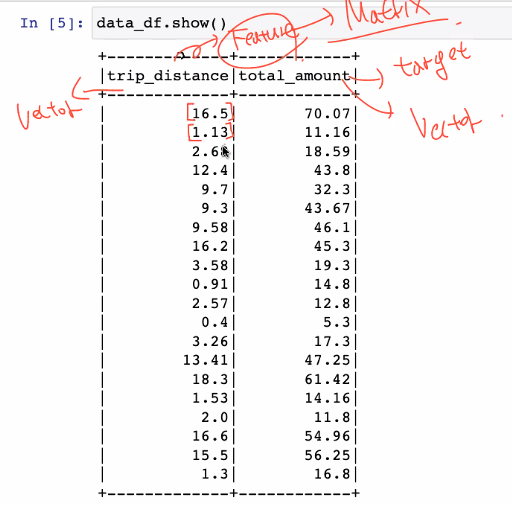
- feature는 matrix 형식이어야 함.
    - `feature`가 하나밖에 없지만 `VectorAssembler` 를 활용해서 1차원 배열 형식으로 각각의 데이터를 만들어 준다.
    - R(N) => R(N*1)
    

# Vector Assemble

In [11]:
from pyspark.ml.feature import VectorAssembler

vec_assembler = VectorAssembler(inputCols=['trip_distance'], outputCol = 'features')

vec_train_df = vec_assembler.transform(train_df)

vec_train_df.show()

+-------------+------------+--------+
|trip_distance|total_amount|features|
+-------------+------------+--------+
|        20.88|       39.05| [20.88]|
|        20.88|       43.05| [20.88]|
|        20.88|        55.3| [20.88]|
|        20.88|       55.56| [20.88]|
|        20.88|       56.55| [20.88]|
|        20.88|        57.3| [20.88]|
|        20.88|       58.05| [20.88]|
|        20.88|        58.3| [20.88]|
|        20.88|       58.55| [20.88]|
|        20.88|       58.63| [20.88]|
|        20.88|       59.35| [20.88]|
|        20.88|       59.92| [20.88]|
|        20.88|       60.55| [20.88]|
|        20.88|        60.6| [20.88]|
|        20.88|        60.6| [20.88]|
|        20.88|        60.6| [20.88]|
|        20.88|        60.6| [20.88]|
|        20.88|        60.6| [20.88]|
|        20.88|        60.6| [20.88]|
|        20.88|        60.6| [20.88]|
+-------------+------------+--------+
only showing top 20 rows



# 모델 생성

In [12]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(
        maxIter = 50,
        labelCol = 'total_amount',
        featuresCol = 'features')


In [13]:
lr_model = lr.fit(vec_train_df)

23/06/14 04:55:34 WARN Instrumentation: [5e4fe460] regParam is zero, which might cause numerical instability and overfitting.
23/06/14 04:55:35 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/06/14 04:55:35 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
23/06/14 04:56:08 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


# test_df 변환

In [14]:
vec_test_df = vec_assembler.transform(test_df)

In [15]:
vec_test_df.show()

+-------------+------------+--------+
|trip_distance|total_amount|features|
+-------------+------------+--------+
|         1.99|         8.3|  [1.99]|
|         1.99|         8.8|  [1.99]|
|         1.99|         8.8|  [1.99]|
|         1.99|         8.8|  [1.99]|
|         1.99|         9.3|  [1.99]|
|         1.99|         9.3|  [1.99]|
|         1.99|         9.3|  [1.99]|
|         1.99|         9.3|  [1.99]|
|         1.99|         9.3|  [1.99]|
|         1.99|         9.3|  [1.99]|
|         1.99|         9.3|  [1.99]|
|         1.99|         9.3|  [1.99]|
|         1.99|         9.3|  [1.99]|
|         1.99|        9.55|  [1.99]|
|         1.99|         9.8|  [1.99]|
|         1.99|         9.8|  [1.99]|
|         1.99|         9.8|  [1.99]|
|         1.99|         9.8|  [1.99]|
|         1.99|        9.81|  [1.99]|
|         1.99|       10.23|  [1.99]|
+-------------+------------+--------+
only showing top 20 rows



# 예측

In [16]:
predictions = lr_model.transform(vec_test_df)
predictions.show()

+-------------+------------+--------+------------------+
|trip_distance|total_amount|features|        prediction|
+-------------+------------+--------+------------------+
|         1.99|         8.3|  [1.99]|15.321356960710837|
|         1.99|         8.8|  [1.99]|15.321356960710837|
|         1.99|         8.8|  [1.99]|15.321356960710837|
|         1.99|         8.8|  [1.99]|15.321356960710837|
|         1.99|         9.3|  [1.99]|15.321356960710837|
|         1.99|         9.3|  [1.99]|15.321356960710837|
|         1.99|         9.3|  [1.99]|15.321356960710837|
|         1.99|         9.3|  [1.99]|15.321356960710837|
|         1.99|         9.3|  [1.99]|15.321356960710837|
|         1.99|         9.3|  [1.99]|15.321356960710837|
|         1.99|         9.3|  [1.99]|15.321356960710837|
|         1.99|         9.3|  [1.99]|15.321356960710837|
|         1.99|         9.3|  [1.99]|15.321356960710837|
|         1.99|        9.55|  [1.99]|15.321356960710837|
|         1.99|         9.8|  [

# 평가

In [17]:
# Evaluator를 쓰지 않고 train 데이터에 대한 rmse 값 확인
lr_model.summary.rootMeanSquaredError

6.1381813996842425

In [18]:
# R^2 확인
lr_model.summary.r2

0.7752743340825037